<a href="https://colab.research.google.com/github/carmenscar/Data-Science-projects/blob/master/Fraud_detection_incredit_cards_algorithm_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Autor:  Carmen Scartezini

# Fraud Detection Model: Improvements with Feature Selection and Data Balancing

<p align=center>
<img src="https://img.freepik.com/vetores-gratis/seguranca-global-de-dados-seguranca-de-dados-pessoais-ilustracao-do-conceito-on-line-de-seguranca-de-dados-ciberneticos-seguranca-da-internet-ou-privacidade-e-protecao-de-informacoes_1150-37350.jpg?t=st=1696358220~exp=1696358820~hmac=9e5494a683115c2c291474b1c5088b0013487cab8dcc2dd60852759d3b0a8282" width="60%"></p>

In Brazil, in the [first quarter of 2023](https://einvestidor.estadao.com.br/ultimas/brasil-dados-tentativas-fraude-dicas-se-proteger/), there were more than 2.8 thousand attempts at financial fraud in electronic channels every minute, credit card fraud has become a growing concern for financial institutions, with significant financial losses and potential negative impacts on users. To address this issue, this project focuses on improving fraud detection through feature selection and data balancing techniques.


By leveraging advanced data science methodologies, we aim to enhance the accuracy and efficiency of fraud detection models specifically using logistic regression. The project starts by carefully **selecting relevant features** from the available dataset, utilizing statistical techniques to identify the most informative variables for fraud prediction within the **logistic regression framework**.


Furthermore, we explore different **data balancing techniques** to address the class imbalance issue commonly encountered in credit card fraud datasets. This involves experimenting with methods such as Random Under Sampling, SMOTE (Synthetic Minority Over-sampling Technique), and adjusting class weights to achieve a more balanced representation of fraud and non-fraud cases within the logistic regression model.


Through this approach, we aim to develop a robust logistic regression model for fraud detection that minimizes false positives while effectively identifying fraudulent transactions. The ultimate goal is to provide financial institutions, such as banks and fintech companies, with a reliable and efficient tool to combat credit card fraud and mitigate its impact on both the institutions and their customers.

## Collecting Data

In this project, we will be using a dataset provided by European credit card companies available in [kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). We accessed the data through kaggle's API.


The dataset contains information about financial transactions that occurred over a period of two days, with 492 fraud cases identified out of nearly 290,000 transactions.


Furthermore, the features in the dataset are all numeric and have been anonymized for privacy and security reasons. They are represented by columns labeled as V1, V2, V3, ..., V28.


As part of the data preparation process, a technique known as Principal Component Analysis (PCA) was applied. PCA allows for dimensionality reduction while retaining as much information as possible. The components resulting from the PCA transformation correspond to the original columns V1 to V28 in this project.

In [1]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek

import statsmodels.api as sm
from scipy import stats
from scipy.stats import ks_2samp
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

!pip install kaggle
import zipfile
from IPython.display import FileLink
from pathlib import Path
import shutil
import zipfile
import csv
import string
import re

# notebook configs
np.random.seed(42)
sns.set_style()

import warnings
warnings.filterwarnings('ignore')

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

In [2]:
# Define path, change permissions (to get token go to 'create new token' in your kaggle profile)
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# The API address for dataset download ('Copy API Command' in kaggle dataset page)
!kaggle datasets download -d mlg-ulb/creditcardfraud

 97% 64.0M/66.0M [00:02<00:00, 44.4MB/s]
100% 66.0M/66.0M [00:02<00:00, 31.2MB/s]


In [3]:
# Path to google colab enviroment
zip_path = "/content/creditcardfraud.zip"

# Open ZIP and take a sneakpic
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_files = zip_ref.namelist()
    for file in zip_files:
        print(file)

creditcard.csv


In [4]:
#Create dataframe
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extract("creditcard.csv", path="/content")

df = pd.read_csv('/content/creditcard.csv')

## Metadata

Just by looking at the first five entries, we can draw some conclusions:

* The first five entries provide an understanding of how the PCA transformation anonymized the features and converted them into numeric values.

* he columns `Time` and `Amount` were preserved, maintaining their original values.

* The target variable is represented in the `Class`:
    * **0:** Normal transaction; and
    * **1:** Fraudulent transaction.

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Checking nulls
df.isnull().sum().max()

0

As stated in the [data description](https://www.kaggle.com/mlg-ulb/creditcardfraud), the entries related to fraudulent transactions account for 0.17% of the total. The bar chart clearly shows this discrepancy. In practice, this affects the model's performance, and it will be necessary to balance the data before feeding it into the final classification model. Given this issue, we will test some models to address it.

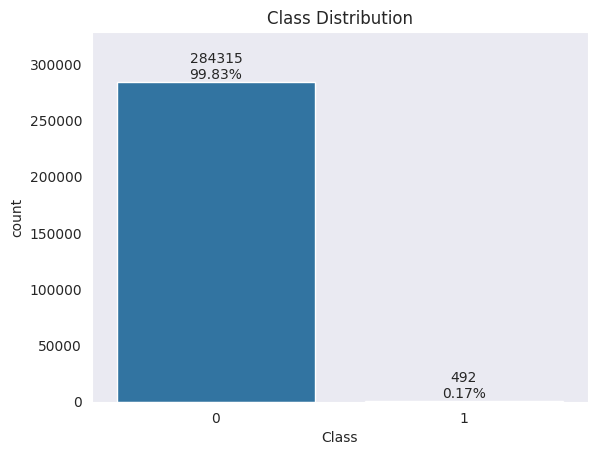

In [ ]:
#  Bar plot
fig, ax = plt.subplots()
sns.countplot(x='Class', data=df, ax=ax)
ax.set_title('Class Distribution')

# Add labels
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}\n{height/total:.2%}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# fitting labels
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)

plt.show()

Two plots were also generated to compare the distributions of the two classes over the time dimension (`Time`). However, no information was identified from the frequency distributions below.

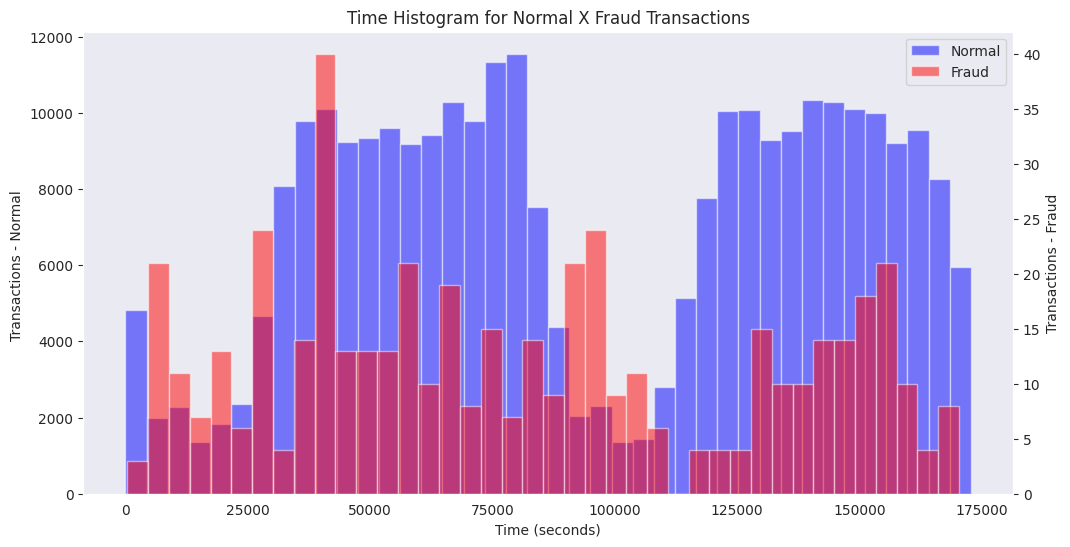

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

num_bins = 40

# Histograma para a classe "Normal"
ax1.hist(df.Time[df.Class == 0], bins=num_bins, color='blue', alpha=0.5, label='Normal')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Transactions - Normal ')
ax1.set_title('Time Histogram for Normal X Fraud Transactions')

# Adiciona um segundo eixo y para a escala de "Fraude"
ax2 = ax1.twinx()
ax2.hist(df.Time[df.Class == 1], bins=num_bins, color='red', alpha=0.5, label='Fraud')

ax2.set_ylabel('Transactions - Fraud')

# Configuração da legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

Continuing with the exploratory analysis, **boxplots** were generated to examine any variations in transaction patterns based on the Amount dimension.


Overall, it is evident that there are distinct distributions for the two classes, which is expected to have a significant impact on the training of the machine learning model.

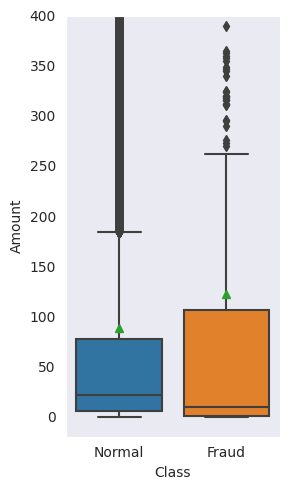

In [ ]:
fig, ax = plt.subplots(figsize=(3,5), sharex=True)

sns.boxplot(x=df.Class, y=df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraud'])

plt.tight_layout()

Here is a small framework to check for analysis and verification of the assumptions of a regression model:

* **Heteroscedasticity**: Use the `Breusch-Pagan test` to check if the variance of the residuals is constant or varies with the values of the independent variables.

* **Autocorrelation of the residuals**: Use the `Durbin-Watson test` to check for autocorrelation in the residuals, i.e., if there is correlation between the residuals at consecutive time points.

* **Correlation between the independent variables**: Assess multicollinearity among the independent variables using the `Variance Inflation Factor (VIF) test` and the `correlation matrix`.

Additionally, you can perform the `Kolmogorov-Smirnov test` to compare the distribution of the target variable with a theoretical distribution, such as the normal distribution. The larger the difference between the distributions, the better the model identifies these differences for making predictions.

By evaluating these assumptions, you can identify potential issues in your regression model and take corrective measures to ensure the validity and reliability of inferences based on the model.

In [ ]:
# dataframe with independent variables
X = df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'
       , 'Amount'
        ]]

#intercept constant
X_int = sm.add_constant(X)

# LR model
model = sm.Logit(df['Class'], X_int)
result = model.fit()

# List os variables that didnt pass the tests
list_variables_to_drop = []

Optimization terminated successfully.
         Current function value: 0.003919
         Iterations 13


##Heteroscedasticity
Heteroscedasticity is an important aspect to evaluate in regression models.
It occurs when the variance of the regression model errors is not constant in relation to the independent variables. To check for the presence of heteroscedasticity, we can use the Breusch-Pagan test. If the **p-value of the test is significant (usually less than 0.05), it indicates evidence of heteroscedasticity in the model**. In this way, we will exclude the variables **V22, V23,** and **V25** with a p-value greater than 0.05.


To deal with heteroscedasticity, we can consider logarithmic transformations, robust linear regression models, or nonlinear regression models. In this case, we will choose to remove the variables with the highest heteroscedasticity to simplify the model.


Heteroscedasticity can affect the interpretation of results and the reliability of statistical inferences. The assumption of homoscedasticity is necessary to obtain correct confidence intervals and hypothesis tests. Additionally, the interpretation of regression coefficients is more straightforward when the variance of the residuals is constant.

In [ ]:
X_temp = X_int.copy()
X_temp['const'] = 1

# DataFrame to input Breusch-Pagan tests
bp_results = pd.DataFrame(columns=['Feature', 'Breusch-Pagan', 'Valor p'])


for variavel in X_int.columns:
    bp_test = het_breuschpagan(df['Class'], X_temp[[variavel, 'const']])
    bp_results = bp_results.append({'Feature': variavel, 'Breusch-Pagan': bp_test[0], 'P-value': bp_test[1]}, ignore_index=True)

pd.set_option('display.float_format', '{:.2f}'.format)

#putting variables in a list
for i in bp_results[bp_results['P-value'] > 0.05]['Feature']:
  if i not in list_variables_to_drop:
    list_variables_to_drop.append(i)

bp_results[bp_results['P-value'] > 0.05]


,Feature,Breusch-Pagan,Valor p,P-value
0,const,-0.00,NaN,1.00
22,V22,0.18,NaN,0.67
23,V23,2.05,NaN,0.15
25,V25,3.12,NaN,0.08


##Autocorrelation of the residuals:

The Durbin-Watson test is used to check for the presence of autocorrelation in the residuals of a regression model. It calculates a statistic that ranges from 0 to 4, where **a value close to 2 indicates the absence of autocorrelation** (Values below 2 indicate positive autocorrelation, while values above 2 indicate negative autocorrelation).



In [ ]:

# Calcule o valor do teste de Durbin-Watson - ausencia de autocorrelação dos resíduos
residuals = result.resid_response.copy()  # Use os resíduos padronizados
dw = durbin_watson(residuals)
print('Durbin-Watson test = ', dw)

Durbin-Watson test =  1.9870186376273704


##Correlation between the independent variables

The `VIF (Variance Inflation Factor) test` calculates a measure of variance inflation for each independent variable, indicating the degree of multicollinearity. VIF values above 5 or 10 are often considered indicative of multicollinearity. Additionally, the `correlation matrix` shows the correlations between the independent variables, allowing for the identification of highly correlated variable pairs.

In this case, we observed that the variable "Amount" is autocorrelated with other variables. Assuming that the "Amount" variable is of interest for the model, based on the analysis of VIF and the correlation matrix, we decided **not to include the variable "V2" in the model**.

In [ ]:
# VIF
vif = pd.DataFrame()
vif["Variável"] = X_int.columns
vif["VIF"] = [variance_inflation_factor(X_int.values, i) for i in range(X_int.shape[1])]

In [ ]:
vif[vif['VIF']>5]

,Variável,VIF
29,Amount,12.12


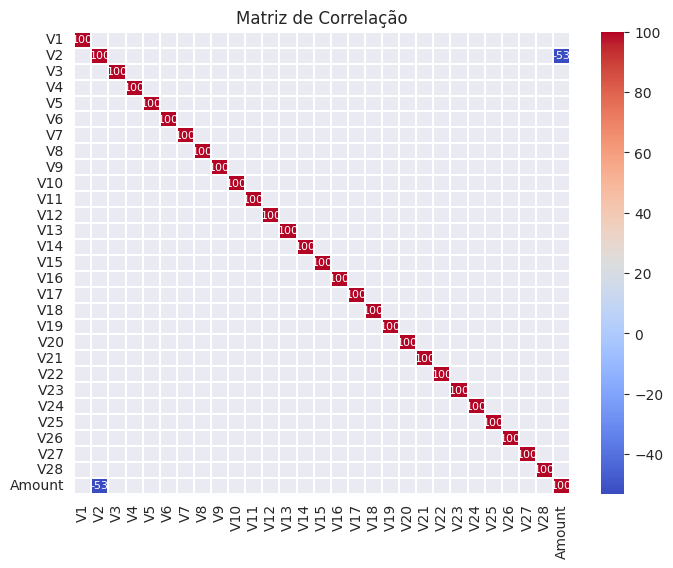

In [ ]:
#Correlation matrix
corr = X.corr()

# Show only corr up to 0.4
mask = corr.abs() <= 0.4
corr_masked = corr.mask(mask)
corr_masked = corr_masked.applymap(lambda x: x*100 if abs(x) > 0.35 else np.nan)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_masked, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=0.1, cmap="coolwarm", ax=ax, annot=True, fmt='.0f', annot_kws={"size": 8})
ax.set_title('Matriz de Correlação')

plt.show()

In [ ]:
list_variables_to_drop += ['V2']

###Kolmogorov-Smirnov test

In the context of comparing the distribution between two different classes, a higher discrepancy in the Kolmogorov-Smirnov test indicates that the classes have distinct distributions. This suggests that the classes are more separable, making it easier for the model to distinguish between them. Therefore, a higher D_test value implies a greater ease for the model in classifying the data.

To simplify the model, we have decided, arbitrarily, that differences smaller than 11% will not be considered. **This means excluding variables V13, V15, V22** (already excluded), **V25 e V26**.

In [ ]:
# KS test
ks_results = pd.DataFrame(columns=['Feature', 'D_test', 'P-value'])

for col in X.columns:
    label_1 = df[df['Class'] == 0][col]
    label_2 = df[df['Class'] == 1][col]
    statistic, p_value = ks_2samp(label_1, label_2)
    ks_results = ks_results.append({'Feature': col, 'D_test': statistic, 'P-value': p_value}, ignore_index=True)

In [ ]:
# showing results
ks_results = pd.DataFrame(ks_results)
for i in ks_results[ks_results['D_test'] <= 0.11]['Feature']:
  if i not in list_variables_to_drop:
    list_variables_to_drop.append(i)

ks_results[ks_results['D_test'] <= 0.11]

,Feature,D_test,P-value
12,V13,0.10,0.00
14,V15,0.06,0.04
21,V22,0.06,0.07
24,V25,0.09,0.00
25,V26,0.09,0.00


In [ ]:
list_variables_to_drop

['const', 'V22', 'V23', 'V25', 'V2', 'V13', 'V15', 'V26']

In this context, it doesn't make sense to use variables with very similar distributions within the same classes because they may not provide additional information or contribute significantly to the detection of anomalies. When variables have similar distributions, they tend to capture similar patterns or information, which can lead to redundancy in the model.


By excluding variables with highly similar distributions, we can reduce the risk of multicollinearity and improve the interpretability and efficiency of the model. It allows us to focus on the variables that offer distinct information and have a greater impact on detecting anomalies.

Take a look in the distribution between variables between the different targets:

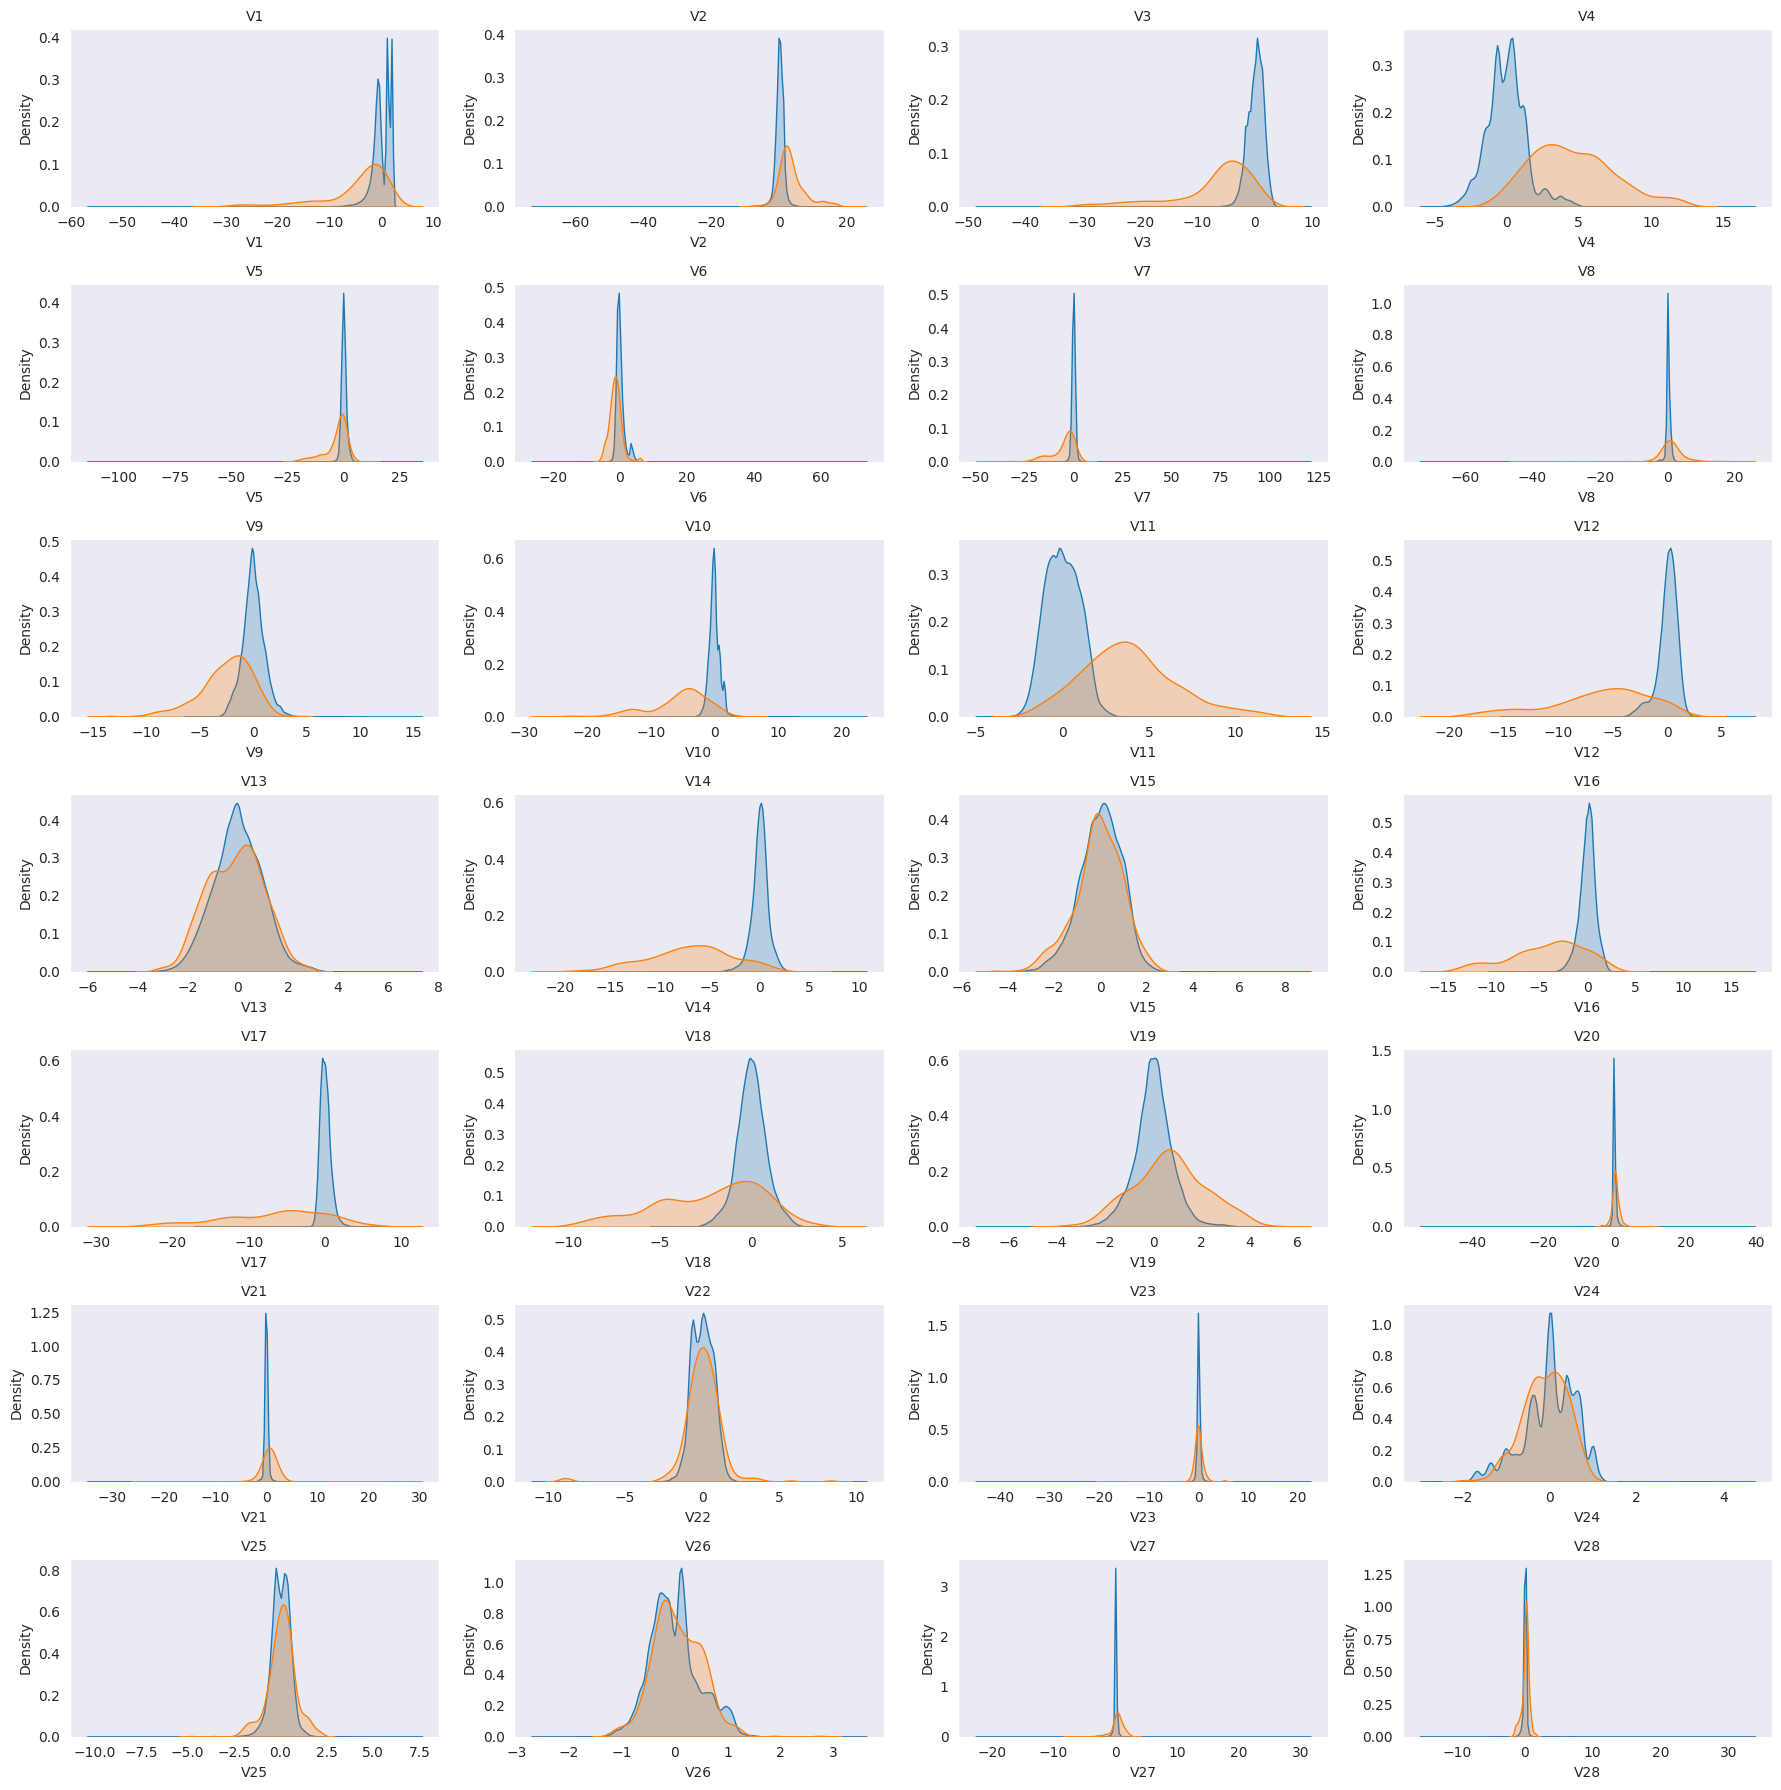

In [ ]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()


In summary, some key observations that could be extracted from this exploratory step are:

* The dataset is highly imbalanced, as fraudulent transactions represent only 0.17% of the total entries.

* There are no missing or null values in the dataframe.

* Since PCA is sensitive to variable scale, it is assumed that the original features have been standardized.

* The Time and Amount columns are not normalized.

* We will exclude the variables that did not pass the test for model simplification, but it is important to note that there are ways to handle these variables.

##Data Preparation
In order to feed the Logistic Regression model that we will build, in this preparation step we will:

* Standardize the `Time` and `Amount` features, which are in different orders of magnitude.
* Split the data into training and testing sets.
* Balance the data to avoid low performance for class 1 and *overfitting*.

###Standardize Time and Amount

For this step, since the Amount column has outliers, we will use standardization using the StandardScaler class.

In [10]:
# Standardize Time and Amount
df_clean = df.copy()
for i in list_variables_to_drop:
  if i in df_clean.columns:
    df_clean.drop(i,axis=1, inplace=True)

In [11]:
std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))
df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)
df_clean.head()

,V1,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V18,V19,V20,V21,V24,V27,V28,Class,std_amount,std_time
0,-1.359807,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,...,0.025791,0.403993,0.251412,-0.018307,0.066928,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,...,-0.183361,-0.145783,-0.069083,-0.225775,-0.339846,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,...,-0.121359,-2.261857,0.524980,0.247998,-0.689281,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,...,1.965775,-1.232622,-0.208038,-0.108300,-1.175575,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,...,-0.038195,0.803487,0.408542,-0.009431,0.141267,0.219422,0.215153,0,-0.073403,-1.996541


**Train and Test split**

To ensure that the training and testing sets have the same proportion of classes, we pass stratify=True.

In [12]:
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

**Imbalanced Data**

For this data balancing step, we decided to test 4 different types of balancing techniques: SMOTE, ADASYN, class_weight rebalancing, and Random Under-Sampling.

* **SMOTE (Synthetic Minority Over-sampling Technique)**: SMOTE is a popular oversampling technique that generates synthetic samples for the minority class by interpolating between existing samples. It helps to balance the class distribution by creating new synthetic instances.

* **ADASYN (Adaptive Synthetic Sampling)**: ADASYN is an extension of SMOTE that adaptively generates synthetic samples by considering the density distribution of the minority class. It focuses more on the samples that are harder to learn by generating more synthetic samples in those regions.

* **Class_weight rebalancing**: This technique involves adjusting the class weights in the logistic regression model to give more importance to the minority class. It is a simple and effective way to address class imbalance by assigning higher weights to the minority class during model training.

* **Random Under-Sampling**: Random Under-Sampling involves randomly removing samples from the majority class to balance the class distribution. This technique reduces the number of majority class samples to match the number of minority class samples.

By testing these different balancing techniques, we aim to find the most effective approach to address the class imbalance in our dataset. Some of this ideas is in [this article](https://towardsdatascience.com/stop-using-smote-to-treat-class-imbalance-take-this-intuitive-approach-instead-9cb822b8dc45)

In [13]:
#SMOTE
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=7)

#RandomUnderSampling
rus = RandomUnderSampler()

#Class weight
count_class_1 = y.value_counts()[0]
count_class_2 = y.value_counts()[1]
ratio = count_class_1/count_class_2
class_weight = {1:ratio, 0:1}

#ADASYN
adasyn = ADASYN(sampling_strategy=1, n_neighbors=5, random_state=7)

#Applying the model

To train the logistic regression model, we used the 4 datasets with the aforementioned balancing techniques applied. Additionally, we also used the unbalanced dataset for comparison of the model evaluation metrics.

In [14]:
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
fpr_list = []
tpr_list = []
lists_metrics = [accuracies,precisions,recalls,f1_scores,roc_aucs,fpr_list,tpr_list]

In [15]:
def model_lr(X_train, y_train, X_test, y_test, class_weight_t, lists, random_state=None):
  np.random.seed(2)
  lr = LogisticRegression(class_weight=class_weight_t, random_state=random_state)
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  y_pred_proba = lr.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
  lists[5].append(fpr)
  lists[6].append(tpr)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  lists[0].append(accuracy)
  lists[1].append(precision)
  lists[2].append(recall)
  lists[3].append(f1)
  lists[4].append(roc_auc)
  return lists

In [16]:
#SMOTE
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_smote, y_train_smote)
lists_metrics_smote = model_lr(X_train_smote, y_train_smote, X_test_smote, y_test_smote, None, lists_metrics, random_state=42)

In [17]:
#RandomUnderSampler
X_train_rus, X_test_rus,  y_train_rus, y_test_rus = train_test_split(X, y, stratify=y, shuffle=True, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train_rus, y_train_rus)
lists_metrics_rus = model_lr(X_train_rus, y_train_rus, X_test_rus, y_test_rus, None, lists_metrics, random_state=123)

In [18]:
#ADASYN
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X, y, stratify=y, shuffle=True, random_state=456)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_adasyn, y_train_adasyn)
lists_metrics_adasyn = model_lr(X_train_adasyn, y_train_adasyn, X_test_adasyn, y_test_adasyn, None, lists_metrics, random_state=456)

In [19]:
#Class Weight
X_train_cw, X_test_cw, y_train_cw, y_test_cw = train_test_split(X, y, stratify=y, shuffle=True, random_state=987)
lists_metrics_cw = model_lr(X_train_cw, y_train_cw, X_test_cw, y_test_cw, class_weight, lists_metrics, random_state=987)

In [20]:
#no balancing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=1345)
lists_metrics = model_lr(X_train, y_train, X_test, y_test, None, lists_metrics, random_state=1345)

#Models evaluation
 In the graphs below, you can see the comparison of applying the logistic regression model on all these datasets.

In [21]:
models = ['SMOTE','Random Under-Sampling', 'ADASYN', 'Weighted Classes', 'No Balancing']
colors = ['blue', 'green', 'orange', 'red', 'yellow']

In [22]:
def bar_plot(evaluation_m, ylabel,title):
  plt.figure(figsize=(9, 2))
  plt.bar(models, evaluation_m, color=colors)
  plt.xlabel('Models')
  plt.ylabel(ylabel)
  plt.title(title, pad=20)
  plt.ylim([0, 1.1])

  for i, acc in enumerate(evaluation_m):
      plt.text(i, acc, f'{acc:.2%}', ha='center', va='bottom')


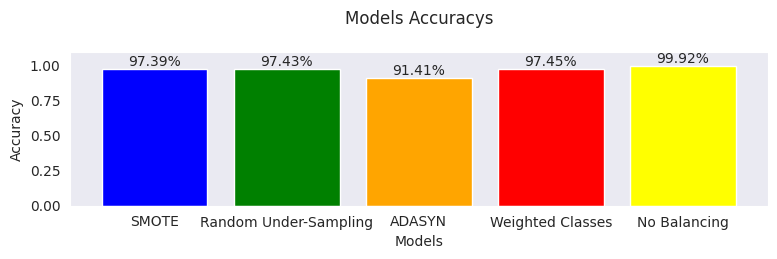

In [23]:
bar_plot(lists_metrics[0],'Accuracy','Models Accuracys')

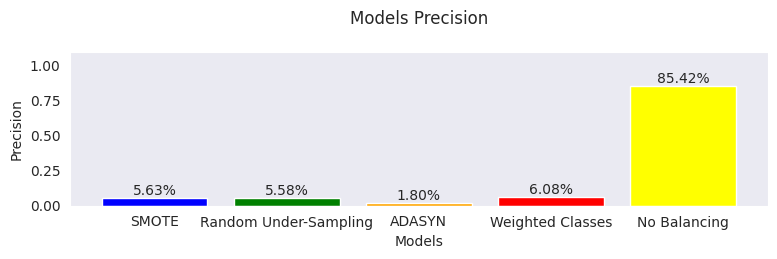

In [24]:
bar_plot(lists_metrics[1],'Precision','Models Precision')

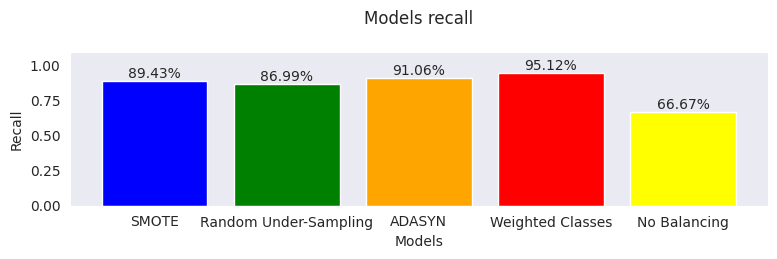

In [25]:
bar_plot(lists_metrics[2],'Recall','Models recall')

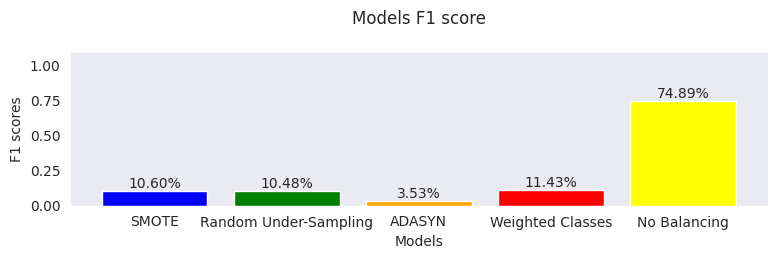

In [26]:
bar_plot(lists_metrics[3],'F1 scores','Models F1 score')

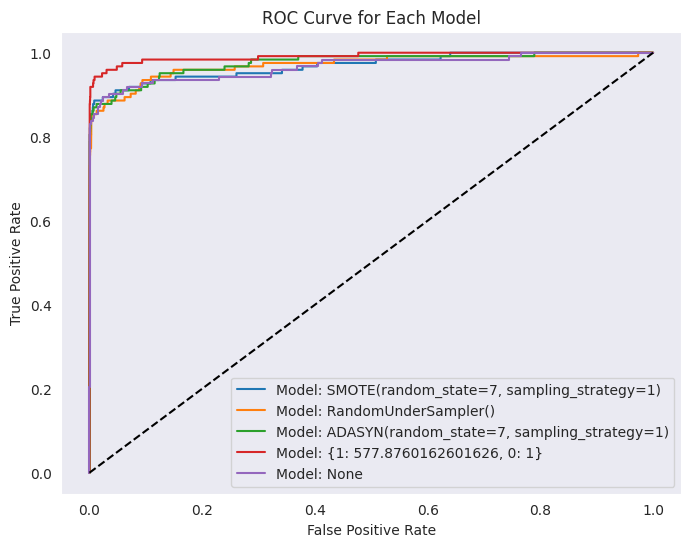

In [30]:
# Plot ROC-curve
plt.figure(figsize=(8, 6))
for fpr, tpr, model in zip(lists_metrics[5], lists_metrics[6], [sm, rus, adasyn, class_weight, None ]):
    plt.plot(fpr, tpr, label='Model: {}'.format(model))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Model')
plt.legend()
plt.show()

In [28]:
data = {
    'Model': models,
    'Accuracy': lists_metrics[0],
    'Precision': lists_metrics[1],
    'Recall': lists_metrics[2],
    'F1 Score': lists_metrics[3],
    'ROC AUC': lists_metrics[4]
}

metrics = pd.DataFrame(data)
print(metrics)

                   Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0                  SMOTE  0.973933   0.056324  0.894309  0.105973  0.934190
1  Random Under-Sampling  0.974327   0.055758  0.869919  0.104799  0.922213
2                 ADASYN  0.914075   0.018009  0.910569  0.035320  0.912325
3       Weighted Classes  0.974523   0.060779  0.951220  0.114258  0.962892
4           No Balancing  0.999228   0.854167  0.666667  0.748858  0.833235


In general, in a credit card fraud detection model, it is common to prioritize **recall** over precision. This is because it is preferable to identify the majority of fraudulent transactions, even if it results in some false positives (blocking legitimate transactions). However, the choice between precision and recall depends on the specific needs and priorities of the business. It is important to consider the financial impact and the tolerance for false positives and false negatives when making this decision.

## Conclusions

As you can see, this is not a trivial problem. In this project, we aimed to improve credit card fraud detection through feature selection and data balancing technique by carefully selecting relevant features and applying data balancing methods, such as Random Under Sampling, SMOTE, ADASYN and class weight adjustment.

The results showed that our approach effectively addressed the challenge of credit card fraud detection. However, there is still potential for further improvements. we recommend exploring other classification algorithms, including deep learning algorithms, optimizing parameters, incorporating additional variables, addressing outliers, and applying ensemble models can be considered to further enhance the accuracy and efficiency of the model.

Overall, this project highlights the importance of feature selection and data balancing in enhancing fraud detection capabilities. By providing financial institutions with reliable tools, we can mitigate financial losses and protect users from fraudulent activities.



### Autor: Carmen Scartezini